# Assignment 3: Traveling Salesman Problem Using Simulated Annealing

In [1]:
from functools import wraps, reduce
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

## 0. Functions

0.1 Set up a decorator function timeit to measure and print the execution time of a wrapped function. 

In [2]:
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

0.2 Set up a function that reads and parses the data from tsp files, and returns the list of city coordinates.

In [3]:
def read_tsp_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    cities = []
    for line in lines:
        parts = line.split()
        if len(parts) == 3 and parts[0].isdigit():
            cities.append((float(parts[1]), float(parts[2])))

    return cities

0.3 Set up a function which normalises the list of city coordinates to 0-1 coordinates. 

In [4]:
def normalise_dist(cities):
    # lambda function to split the coordinates into separate lists, 'x_coord','y_coord' 
    devider = lambda cities: ([city[0] for city in cities], [city[1] for city in cities])
    x_coord, y_coord = devider(cities)
    # get minmax values of both coordinates
    minmax_x = (min(x_coord), max(x_coord))
    minmax_y = (min(y_coord), max(y_coord))
    # lambda functioon to normalize the coordinates with the range 
    normalizer = lambda minmax_x, x_coord: [(x - minmax_x[0]) / (minmax_x[1] - minmax_x[0]) for x in x_coord]
    # get normalized values of both coordinates 
    normalized_x = normalizer(minmax_x, x_coord)
    normalized_y = normalizer(minmax_y, y_coord)
    # lambda function to recouple normalized x and y coordinates for each city
    reconstructor = lambda a, b: (a, b)
    # final normalized list
    normalised = list(map(reconstructor, normalized_x, normalized_y))
    return normalised

0.4 Set up a function which reverses the normalization of the list of city coordinates from 0-1 coordinates back to the original values.

In [5]:
def denormalise_dist(cities, norm_coord):
    # lambda function to split the coordinates into separate lists, 'x_coord','y_coord' 
    devider = lambda cities: ([city[0] for city in cities], [city[1] for city in cities])
    x_coord, y_coord = devider(cities)
    x_norm , y_norm = devider(norm_coord)
    # get minmax values of both coordinates
    minmax_x = (min(x_coord), max(x_coord))
    minmax_y = (min(y_coord), max(y_coord))
    # lambda function to calculate the original coordinates
    denormalize = lambda minmax, norm_coords: [x * (minmax[1] - minmax[0]) + minmax[0] for x in norm_coords]
    denormalized_x = denormalize(minmax_x, x_norm)
    denormalized_y = denormalize(minmax_y, y_norm)
    # lambda function to recouple normadelized x and y coordinates for each city
    reconstructor = lambda a, b: (a, b)
    denormalised = list(map(reconstructor, denormalized_x, denormalized_y))
    return denormalised

0.5 Set up a function which calculates the total distance covered in a given tour of the cities.

In [6]:
def calculate_total_distance(tour, cities):
    total_distance = 0
    for i in range(len(tour) - 1):
        city1 = cities[tour[i]]
        city2 = cities[tour[i + 1]]
        distance = math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)
        total_distance += distance

    # return to the starting city
    total_distance += math.sqrt((cities[tour[-1]][0] - cities[tour[0]][0])**2 +
                                (cities[tour[-1]][1] - cities[tour[0]][1])**2)

    return total_distance

0.6. Set up functions to ammend the tours 

0.6.1 Set up a function which "moves" a single city's position within a given tour from i to j  

In [7]:
def move_city(tour):
    i, j = random.sample(range(1, len(tour)-1), 2)
    city = tour.pop(i)
    tour.insert(j, city)
    return tour

0.6.2 Set up a function which "moves" a whole section of the tour to a new (random) position 

In [8]:
def move_part(route):
    i, j = sorted(random.sample(range(1, len(route)-1), 2))
    route_slice = route[i:j]
    del route[i:j]
    if len(route) - 1 > 0:
        new_position = random.randint(1, len(route) - 1)
    else:
        new_position = 1
    route[new_position:new_position] = route_slice
    return route

0.6.3 Set up a function to implement a 2-opt swap operation for a deterministic algorithm. The 2-opt swap is a local search heuristic that attempts to improve a given route by reversing a portion of it. 

In [9]:
def two_opt(tour):
    # apply 2-opt move
    i, j = random.sample(range(len(tour)), 2)
    i, j = sorted([i, j])
    new_tour = tour[:i] + tour[i:j+1][::-1] + tour[j+1:]
    return new_tour

In [10]:
def two_opt_swap(route, i, j):
    new_route = route[:i] + route[i:j + 1][::-1] + route[j + 1:]
    return new_route

In [11]:
def optimise_with_2opt(route, cities):
    """The determenistic alg for 2-opt swap on best result."""
    improvement = True
    best_route = route
    best_distance = calculate_total_distance(route, cities)
    while improvement:
        improvement = False
        for i in range(1, len(best_route) - 1):
            for j in range(i + 1, len(best_route)):
                new_route = two_opt_swap(best_route, i, j)
                new_distance = calculate_total_distance(new_route, cities)
                if new_distance < best_distance:
                    best_distance = new_distance
                    best_route = new_route
                    improvement = True
                    break
            if improvement:
                break

    return best_route

0.7 Set up the cooling schedule functions

0.7.1 Logarithmic cooling

In [12]:
def Hoffmann_Salamon_cooling(iter, D = 10):
        return (D-1)/math.log(iter + 2)

0.7.2 Exponential cooling

In [13]:
def exponential_cooling(temp, rate):
        return temp*rate

0.7.3 Fast cooling

In [14]:
def fast_cooling(iteatr, initial):
        return initial/(1+iteatr)

0.9. Set up functions to run versions of the simulated annealing method

0.9.1 Set up the function to run the simulated annealing method on a given TSP set up, with a defined intitial temperature parameter value and cooling schedule, taking into account 2-opt and move city optimizations ('tomc')

In [15]:
def simulated_annealing_tomc(cities, initial_temperature=1000, cooling_rate=0.995, num_iterations=10000):
    num_cities = len(cities)
    current_tour = list(range(num_cities))
    random.shuffle(current_tour)
    current_distance = calculate_total_distance(current_tour, cities)

    best_tour = current_tour[:]
    best_distance = current_distance

    temperature = initial_temperature

    for iteration in range(num_iterations):
        # Choose a random elementary edit
        if random.uniform(0, 1) < 0.5:
            new_tour = two_opt(current_tour)
        else:
            new_tour = move_city(current_tour)

        # Calculate the new tour distance
        new_distance = calculate_total_distance(new_tour, cities)

        # Decide whether to accept the new tour
        if new_distance < current_distance or random.uniform(0, 1) < math.exp((current_distance - new_distance) / temperature):
            current_tour = new_tour
            current_distance = new_distance

            # Update the best tour if needed
            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance

        # Cool down the temperature
        temperature *= cooling_rate

    return best_tour, best_distance

0.9.2 Set up the function to run the default simulated annealing method on a given TSP set up, with a defined intitial temperature parameter value and cooling schedule

In [16]:
@timeit
def simulated_annealing(cities, initial_temperature, cooling_rate):

    num_cities = len(cities)
    current_tour = list(range(num_cities))
    current_distance = calculate_total_distance(current_tour, cities)
    best_tour = current_tour[:]
    best_distance = current_distance
    temperature = initial_temperature
    temp_array = []
    prob_array = []
    t = []
    fitnes = []
    fitnes_t = []
    temp_t = []
    bb = []
    no_progress = 0
    
    """Outer loop for the cooling schedule"""
    for inner_ier in range(3000):
        
        a = [1,1,2,3,3,4]
        max_iterations = 3000

        """Inner loop (Markov Chain length)"""
        for iteration in range(max_iterations):
        
            new_tour = current_tour[:]
            u = random.sample(a, 1)
        
            if u[0] == 1:
            # 2opt swap
                tik = 1
                i, j = sorted(random.sample(range(1, num_cities), 2))
                new_tour[i:j+1] = list(reversed(new_tour[i:j+1]))
            elif u[0] == 2:
            # move city 
                tik = 2
                new_tour = move_city(new_tour)
            elif u[0] == 3:
            # move part
                tik = 3
                new_tour = move_part(new_tour)
            elif u[0] == 4:
                # reverse two adjacent neigbours
                tik = 4
                i, j = random.sample(range(1, num_cities), 2)
                tem = new_tour[i]
                try: 
                    new_tour[i] = new_tour[i+1]
                    new_tour[i+1] = tem
                except: 
                    new_tour[i] = new_tour[i-1]
                    new_tour[i-1] = tem
                
            # calculate the new tour distance
            new_distance = calculate_total_distance(new_tour, cities)
            delta_distance = new_distance - current_distance
        
            # decide whether to accept the new tour
            if delta_distance <= 0:
                fitnes.append(new_distance)
                fitnes_t.append((inner_ier)*max_iterations +iteration) 
                bb.append(best_distance)
                current_tour = new_tour
                current_distance = new_distance
                # update the best tour if needed
                if new_distance < best_distance:
                    best_tour = new_tour
                    best_distance = new_distance
                    print(best_distance)
                    no_progress =0
                else:
                    no_progress += 1
            else:
                no_progress += 1
                argument = -delta_distance / temperature
                random_u = random.uniform(0, 1)
                prob_array.append(math.exp(argument))
                t.append((inner_ier)*max_iterations +iteration) 
                if math.exp(argument) > random_u:
                    current_tour = new_tour
                    current_distance = new_distance

    
        temperature = exponential_cooling(temperature, cooling_rate)
        
        # reaneiling
        if temperature < 0.1 and no_progress > 50:
            best_route_2opt = optimise_with_2opt(best_tour, cities)
            best_dist_2opt = calculate_total_distance(best_route_2opt, cities)
            if best_dist_2opt == best_distance:
                temperature = 3
                print("gg")
            
        temp_array.append(temperature)
        temp_t.append(inner_ier)                       
      
    return best_tour, best_distance ,temp_array, prob_array, t, fitnes, fitnes_t, temp_t, bb

0.10 Set up a function to plot a given tour of the cities

In [17]:
def plot_tour(tour, cities):
    x = [cities[city][0] for city in tour]
    y = [cities[city][1] for city in tour]
    x.append(x[0])
    y.append(y[0])
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'o-', label='Tour Path')
    plt.plot([cities[i][0] for i in range(len(cities))], 
             [cities[i][1] for i in range(len(cities))], 
             'o', label='Cities')
    
    plt.title('Traveling Salesman Problem - Simulated Annealing')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.show()

0.11.1 Set up a function to run multiple simulated_annealing simulations

In [18]:
def run_multiple_simulations(cities, num_simulations=100):
    best_overall_tour = None
    best_overall_distance = float('inf')

    for i in range(num_simulations):
        #print(f"Running Simulation {i + 1}")
        current_tour, current_distance = simulated_annealing(cities)
        if current_distance < best_overall_distance:
            best_overall_tour = current_tour
            best_overall_distance = current_distance

    return best_overall_tour, best_overall_distance

0.11.1 Set up a function to run multiple tomc simulated_annealing simulations

In [19]:
def run_multiple_simulations_tomc(cities, num_simulations=100):
    best_overall_tour = None
    best_overall_distance = float('inf')

    for i in range(num_simulations):
        #print(f"Running Simulation {i + 1}")
        current_tour, current_distance = simulated_annealing_tomc(cities)
        if current_distance < best_overall_distance:
            best_overall_tour = current_tour
            best_overall_distance = current_distance

    return best_overall_tour, best_overall_distance

0.12 Set up a function to find the best hyperparameters for a given TSP

In [20]:
# too long to run, delete if not used
def param_search(cities, initial_temp, cooling_rate, in_temp=0.05, col_rate=0.95, max_no_improve=30):
    """ Simulated aneiling to find best hyperparameters for TSP"""
    curr_temp = initial_temp
    curr_rate = cooling_rate
    best_tour, best_distance_init, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing(cities, initial_temp, cooling_rate)
    
    temperature = in_temp
    best_abs = np.inf
    best_initial_temp = 0 
    best_cooling_rate = 0
    no_improve_counter = 0

    log = []

    for k in range(150):
        step_size_temp = 2.5 / (1 + k)  
        step_size_rate = 0.01 / (1 + k)  

        mean_len = []
        improved = False

        for i in range(4):
            u = random.uniform(-step_size_temp, step_size_temp) 
            new_temp = max(curr_temp + u, 0.1) 
            u = random.uniform(-step_size_rate, step_size_rate) 
            new_rate = min(max(curr_rate + u, 0.01), 0.999) 

            for b in range(7):
                best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing(cities, new_temp, new_rate)
                mean_len.append(best_distance)

            mean_len_v = np.mean(mean_len)
            delta_distance = mean_len_v - best_distance_init
            argument = -delta_distance / temperature
            random_u = random.uniform(0, 1)

            if delta_distance < 0 or math.exp(argument) > random_u:
                curr_temp = new_temp
                curr_rate = new_rate
                best_distance_init = mean_len_v
                print(step_size_temp)
                if best_distance_init < best_abs:
                    best_abs = best_distance_init
                    print(f"Abs best:{best_abs}")
                    print(f"cur temp:{temperature}")
                    print(f"new_temp :{new_temp}")
                    print(f"new_rate:{new_rate}")
                    best_initial_temp = curr_temp 
                    best_cooling_rate = curr_rate
                    improved = True

        log.append((k, curr_temp, curr_rate, best_abs))

        if not improved:
            no_improve_counter += 1
        else:
            no_improve_counter = 0

        if no_improve_counter >= max_no_improve:
            print("Stopping early due to no improvement.")
            break

        temperature *= col_rate

    return best_abs, best_initial_temp, best_cooling_rate, log


## 1. Test Runs: General

1.1 Test effect of delta and initial temperature on cooling schedule. 

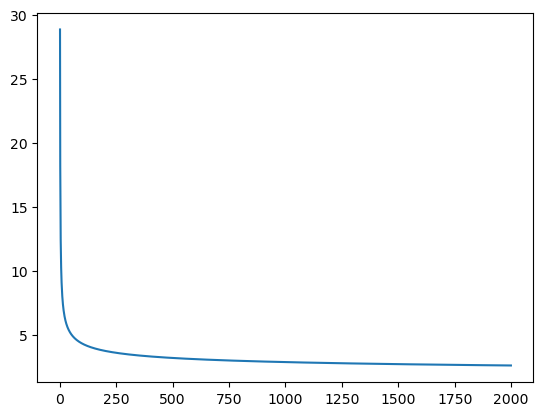

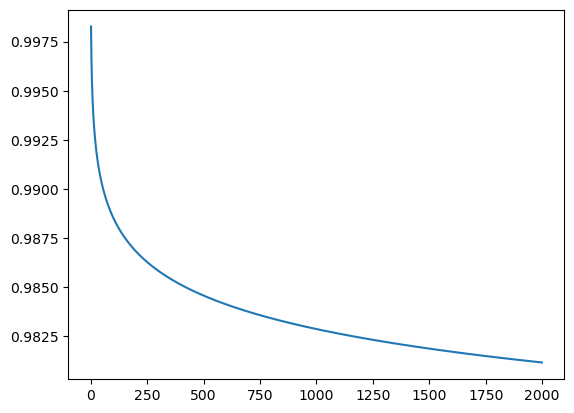

In [21]:
temperature = 20
initial_temperature = 20
ar = []
ir = []
pr = []
for i in range(1, 2000):
    temperature =  initial_temperature / (np.log(i + 1))
    ar.append(temperature)
    ir.append(i)
    argument = -0.05 / temperature
    pr.append(math.exp(argument))
plt.plot(ir, ar)
plt.show()
plt.plot(ir, pr)

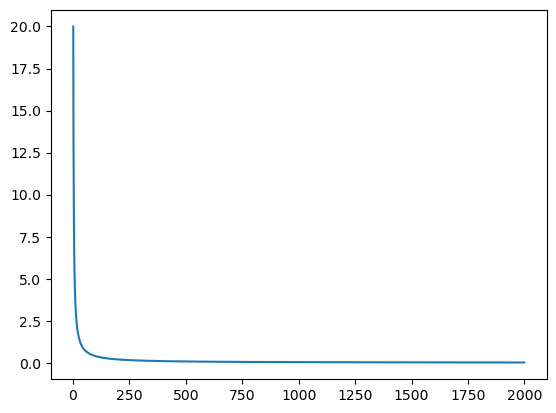

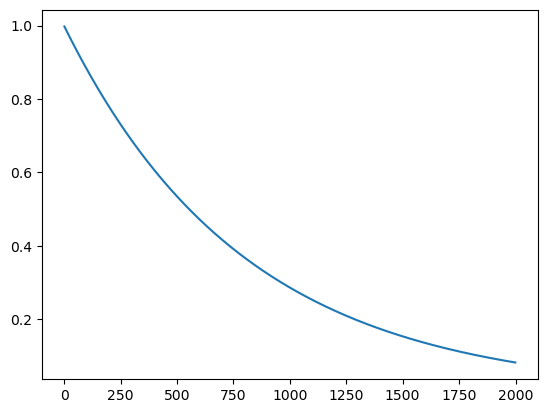

In [22]:
temperature = 20
initial_temperature = 40
ar = []
ir = []
pr = []
for i in range(1, 2000):
    temperature =  initial_temperature / (1 + i)
    ar.append(temperature)
    ir.append(i)
    argument = -0.05 / temperature
    pr.append(math.exp(argument))

plt.plot(ir, ar)
plt.show()
plt.plot(ir, pr)

## 2. Test Runs: TSP - Configuration: EIL51

In [23]:
os.getcwd()

'/Users/aleksandar/Documents/GitHub/simulated_annealing'

2.1 Set up the file extraction

In [24]:
# the path to the folder containing the csv file
folder_path = 'TSP-Configurations/'

# the name of the csv file you want to read
file_name = 'eil51.tsp.txt'

# combine the folder path and file name to create the file path
file_path = folder_path + file_name

2.2 Run the default simulated annealing simulation

2.2.1 Initialization with a fixed cooling rate

In [25]:
tsp_file_path = file_path
cities = read_tsp_file(tsp_file_path)
random.shuffle(cities)
cities_norm = normalise_dist(cities)
    
initial_temp = 1400
cooling_rate = 0.995 

2.2.2 Estimate the best tour route and distance 

In [26]:
best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing(cities,initial_temp,cooling_rate)

1720.13066124429
1704.4384725106875
1668.7748310924912
1602.005542325549
1591.7746547664935
1584.5176087660868
1579.675678667588
1558.1046301801875
1536.244291335081
1509.5723761054942
1495.6917350643976
1474.1537604842547
1462.366223749706
1428.4097117452966
1427.5024020932385
1422.6317724227742
1390.1067288230674
1389.8763928911146
1382.3963154226526
1353.6998070660272
1344.0612244205008
1334.529052516734
1323.720443325695
1314.5379171906588
1314.259444443569
1309.6028727134421
1281.9466398924005
1278.4143903641695
1266.8525405804494
1258.7583173981302
1220.6828069754035
1176.808252640326
1170.27308419883
1163.4902254186488
1162.517339535754
1151.1657424780203
1145.3163944467026
1129.897969869424
1128.5768416659416
1118.9225962179578
1117.4931222735709
1098.9644566668544
1089.3562816542492
1061.5696258025669
1058.343878937348
1046.8748908505897
1039.412027374956
1038.7823590990163
1029.2056920372836
1026.9143200915237
1025.5009897859184
1012.7246292546156
987.5059312273452
973.157335

2.2.3 Decouple the coordinates

In [27]:
x = [cities[city][0] for city in best_tour]
y = [cities[city][1] for city in best_tour]
x.append(x[0])
y.append(y[0])

2.2.4 Calculate best total distance

In [28]:
best_distance = calculate_total_distance(best_tour, cities)

2.2.5 Plot the best route

Best Tour: [0, 33, 47, 35, 24, 42, 8, 38, 13, 44, 29, 39, 20, 46, 37, 5, 9, 28, 12, 40, 50, 16, 26, 10, 31, 32, 41, 23, 4, 14, 43, 3, 48, 19, 30, 7, 1, 45, 2, 36, 27, 21, 22, 34, 15, 11, 6, 25, 49, 18, 17]
Best Distance: 428.98164717220686


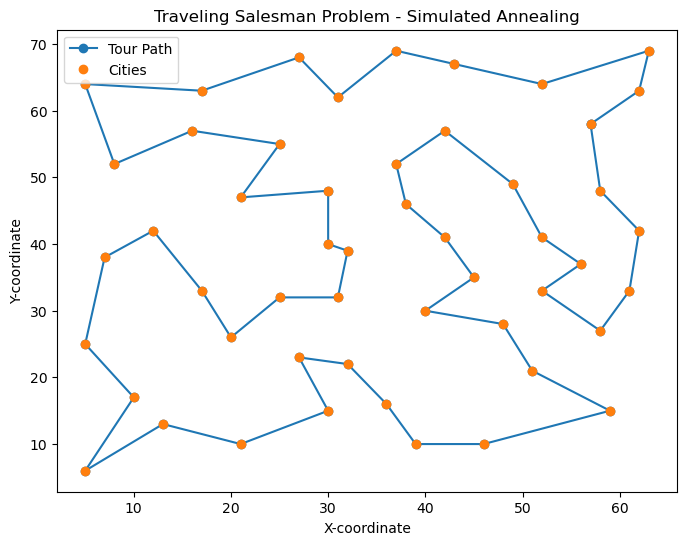

In [29]:
print("Best Tour:", best_tour)
print("Best Distance:", best_distance)
plot_tour(best_tour, cities)

2.2.6 Apply further optimization options on the best_tour

In [30]:
best_route_2opt = optimise_with_2opt(best_tour, cities)
best_dist_2opt = calculate_total_distance(best_route_2opt, cities)
print("Best Distance_2opt:", best_dist_2opt)

Best Distance_2opt: 428.98164717220686


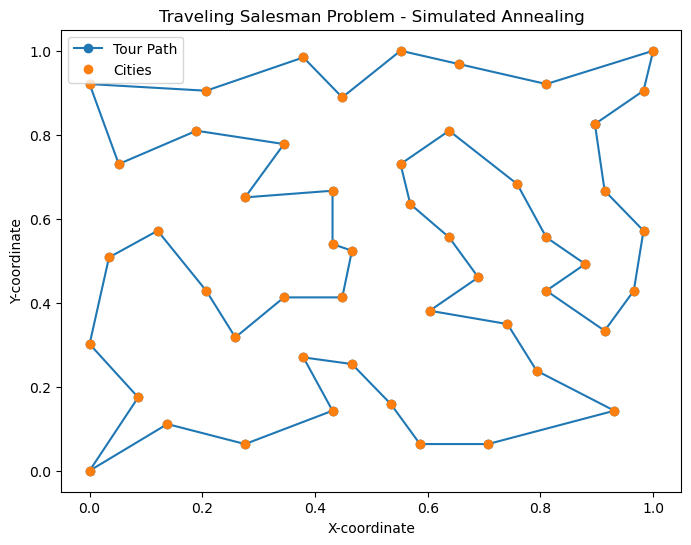

In [31]:
coord_denorm = list(zip(x, y))
plot_tour(best_tour, cities_norm)

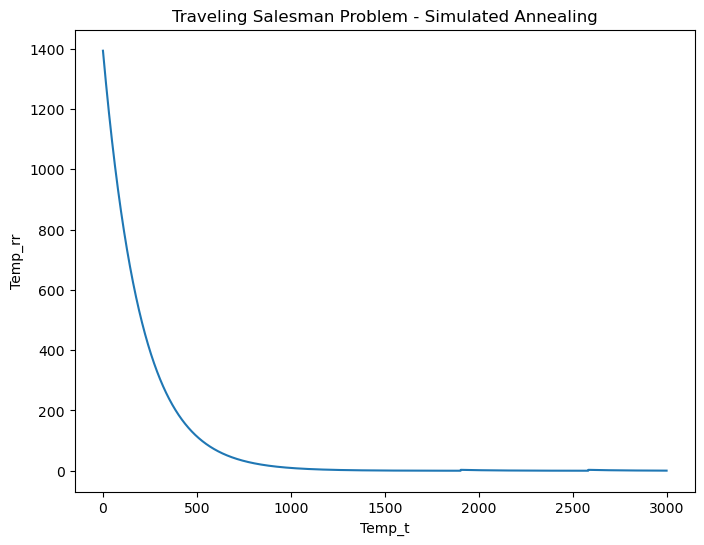

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(temp_t, temp_arr)
plt.title('Traveling Salesman Problem - Simulated Annealing')
plt.xlabel('Temp_t')
plt.ylabel('Temp_rr')
plt.show()

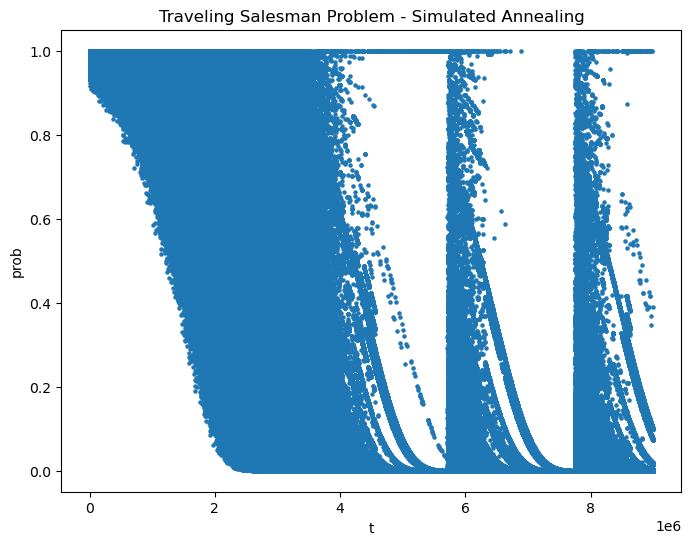

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(t, prob, s=5, label='Data Points')
plt.title('Traveling Salesman Problem - Simulated Annealing')
plt.xlabel('t')
plt.ylabel('prob')
plt.show()

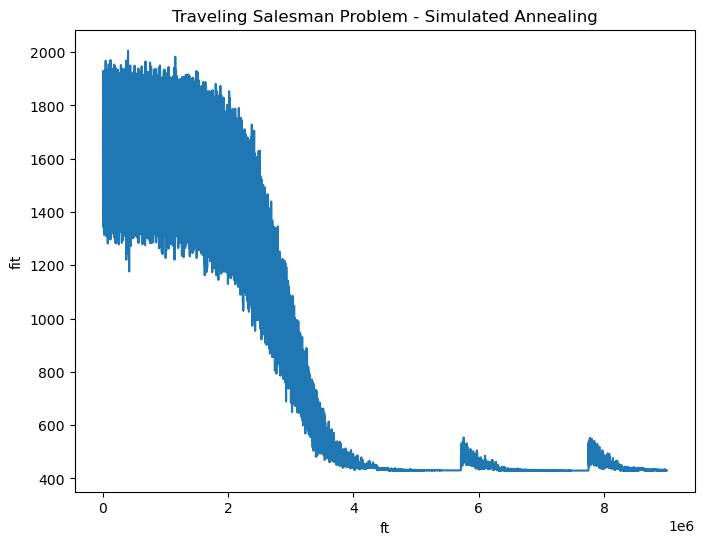

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(ft, fit)
plt.title('Traveling Salesman Problem - Simulated Annealing')
plt.xlabel('ft')
plt.ylabel('fit')
plt.show()

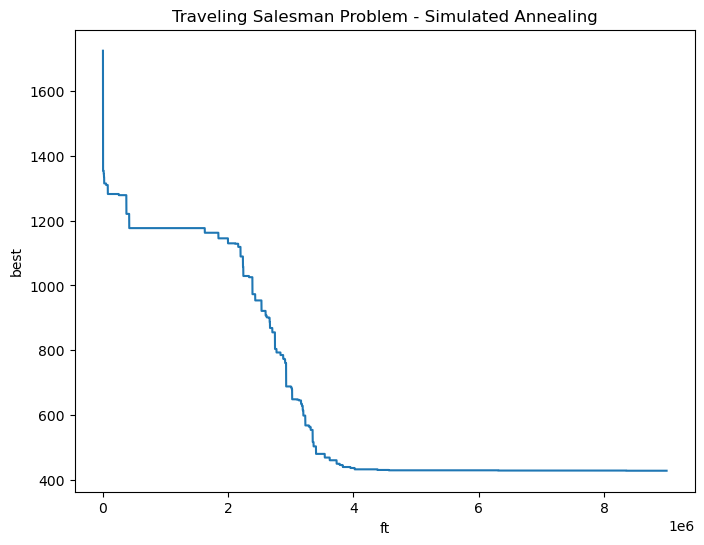

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(ft, best)
plt.title('Traveling Salesman Problem - Simulated Annealing')
plt.xlabel('ft')
plt.ylabel('best')
plt.show()

In [37]:
print(best_dist_2opt)

428.98164717220686


2.3.1 Run the simulated annealing method with the 2-opt and move-city corrections

Best Tour: [35, 2, 15, 28, 45, 32, 14, 34, 36, 18, 8, 50, 20, 41, 31, 17, 1, 3, 43, 26, 6, 19, 16, 5, 39, 7, 25, 33, 40, 46, 4, 22, 12, 49, 29, 37, 44, 30, 24, 48, 47, 0, 21, 42, 23, 13, 27, 9, 38, 10, 11]
Best Distance: 1285.4172216509678


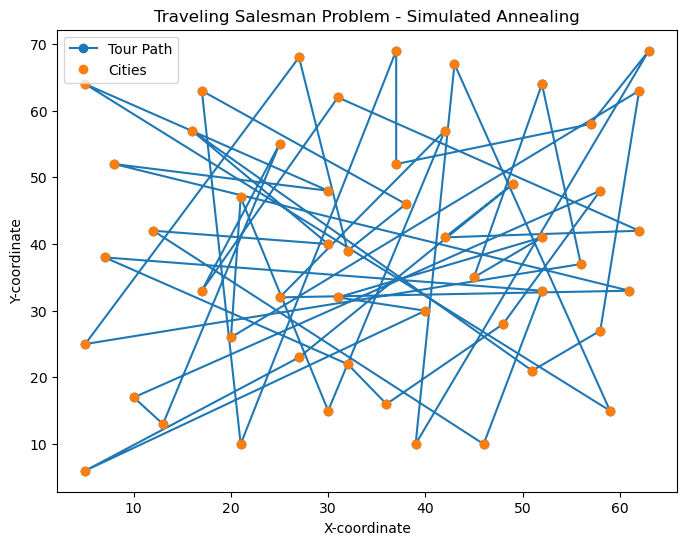

In [38]:
best_tour, best_distance = simulated_annealing_tomc(cities)
print("Best Tour:", best_tour)
print("Best Distance:", best_distance)
plot_tour(best_tour, cities)

2.3.2 Run multiple simulations of simulated annealing method with the 2-opt and move-city corrections

Best Tour: [49, 25, 31, 23, 10, 39, 12, 26, 13, 20, 46, 28, 9, 1, 2, 8, 38, 3, 37, 27, 5, 7, 30, 6, 15, 16, 14, 48, 19, 42, 21, 40, 44, 29, 50, 32, 41, 4, 43, 45, 47, 24, 33, 11, 36, 22, 18, 35, 0, 34, 17]
Best Distance: 1058.4407331980376


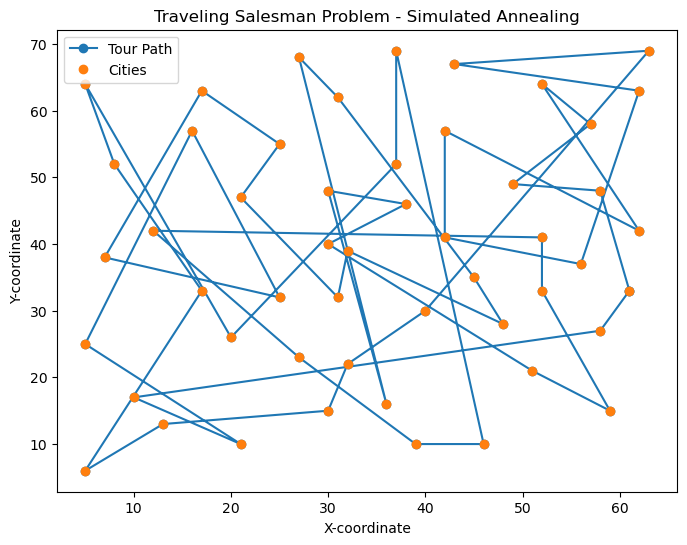

In [39]:
best_tour, best_distance = run_multiple_simulations_tomc(cities, num_simulations=3000)
print("Best Tour:", best_tour)
print("Best Distance:", best_distance)
plot_tour(best_tour, cities)

## 3. Test Runs: TSP - Configuration: A280

In [41]:
# the name of the csv file you want to read
file_name = 'a280.tsp.txt'

# combine the folder path and file name to create the file path
file_path_a280 = folder_path + file_name

In [42]:
tsp_file_path_a280 = file_path_a280
cities_a280 = read_tsp_file(tsp_file_path_a280)
random.shuffle(cities_a280)
cities_norm_a280 = normalise_dist(cities_a280)
    
initial_temp = 1400
cooling_rate = 0.995 

In [43]:
best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing(cities_a280,initial_temp,cooling_rate)

32368.794988269456
32302.73235261078
32222.93466181106
32175.11883091377
32126.784874356275
32086.883912620386
32043.880801005263
31952.0089856948
31945.517328593316
31665.409842095785
31480.02912088804
31369.137097100836
31303.004339447813
31086.197945316202
30849.985910338855
30724.989484149573
30695.77297470334
30605.881870549933
30599.64701437271
30590.59232378664
30475.813798437077
30409.46164674848
30170.08859014539
30169.2367893982
29997.83181222855
29899.481456731588
29809.758504424368
29710.493717948317
29698.117202771697
29550.066310120088
29542.875945582397
29494.211747057412
29468.627939363472
29405.20462703926
29404.734844319315
29201.811945993286
29089.68680597117
28992.269608281134
28982.312069466087
28971.89463922779
28958.335565055666
28935.80951791594
28880.059923937497
28862.40291111129
28701.607694066544
28619.907306286892
28494.333233614714
28434.19667541831
28337.907971854256
28116.000880013322
28088.186795701928
28078.27396495122
28067.0955240172
27936.8791181692

11581.228335737009
11576.11940723573
11572.099301321228
11444.05841811309
11387.768999453416
11386.343834774429
11326.238734527129
11247.599707603616
11222.958776398751
11197.674907996243
11193.241177785614
11119.59229233282
11109.714140575228
11100.779193644907
11098.671236146929
11048.657161213638
11042.729654586317
11012.41400506814
10998.140441214151
10960.863855072279
10941.980837437428
10905.489071950322
10904.844482099636
10894.119315209224
10889.982678417326
10837.228992506656
10805.927739980514
10785.665609424646
10769.535776922143
10758.29712065869
10739.175371380226
10718.661786881637
10715.677525304649
10698.801363329314
10696.521394612028
10642.147660130142
10640.837025998662
10633.899058426305
10575.812580522186
10572.130703605217
10509.034402420273
10506.784388582333
10499.681744717469
10444.955759627659
10442.714492941308
10438.891953559214
10413.158844911663
10410.796024037207
10397.099210306784
10391.441413426204
10369.578585176614
10366.541143203383
10330.75468334393

5037.943287355307
5037.353538503558
5027.972454707679
5027.099910027095
5026.373394958599
5023.822750896215
5022.397586217228
5020.354288721357
5017.321811781953
5004.768765064795
5001.888152980942
4995.369504395771
4986.439114302906
4981.930965580298
4962.145753107682
4955.636168210635
4939.162840626332
4903.44295499258
4887.035314020334
4883.051373341383
4878.550395251282
4875.21970483062
4872.255152902353
4862.366609082355
4849.163668064883
4847.518291082243
4839.428595754426
4836.002123830226
4820.002123830226
4809.175811636282
4788.4796244899035
4783.823250753615
4774.450667751585
4771.024195827385
4764.6547592383995
4761.167797606028
4760.781464594038
4749.467756095053
4747.128506448669
4741.926254129687
4740.5010894506995
4733.046946150486
4706.143837352257
4698.378958531873
4682.378958531873
4676.288908723769
4676.248715094296
4664.915378895942
4663.8774973832515
4659.827534777059
4647.801918175117
4617.426806266677
4614.923022768908
4613.4978580899215
4611.482370872283
4581.49

2681.315432272408
2678.0017237734232
2678.0017237734214
2674.4763137320574
2674.4763137320565
2674.354617977418
gg
2670.488963469114
2669.481219860295
2668.0560551813082
2667.501809907019
2667.501809907017
gg
Function Took 368.0592 seconds


In [45]:
x = [cities_a280[city][0] for city in best_tour]
y = [cities_a280[city][1] for city in best_tour]
x.append(x[0])
y.append(y[0])

In [47]:
best_distance = calculate_total_distance(best_tour, cities_a280)

Best Tour for A280: [0, 233, 193, 273, 155, 149, 57, 197, 94, 71, 143, 239, 182, 45, 125, 174, 58, 266, 108, 220, 204, 268, 243, 244, 258, 262, 189, 101, 270, 226, 141, 265, 192, 178, 260, 209, 222, 181, 216, 150, 35, 147, 46, 215, 267, 259, 198, 202, 170, 116, 146, 97, 269, 105, 60, 236, 55, 254, 156, 92, 25, 194, 161, 165, 196, 171, 223, 195, 271, 127, 18, 231, 264, 91, 89, 106, 162, 107, 163, 29, 180, 74, 131, 142, 52, 228, 34, 78, 274, 207, 275, 225, 154, 119, 263, 175, 248, 51, 2, 39, 117, 63, 130, 114, 179, 99, 246, 100, 3, 113, 123, 70, 160, 217, 251, 69, 20, 104, 103, 166, 38, 7, 206, 232, 72, 229, 56, 86, 136, 40, 218, 187, 4, 30, 11, 126, 73, 214, 37, 238, 10, 76, 80, 21, 237, 199, 132, 245, 255, 159, 138, 64, 61, 79, 172, 115, 6, 256, 240, 247, 148, 128, 122, 230, 47, 8, 44, 110, 133, 184, 224, 201, 252, 210, 124, 121, 93, 41, 54, 96, 85, 250, 15, 208, 164, 53, 278, 176, 118, 191, 134, 36, 144, 137, 261, 68, 145, 31, 26, 219, 62, 98, 277, 84, 242, 16, 200, 66, 42, 88, 185, 1

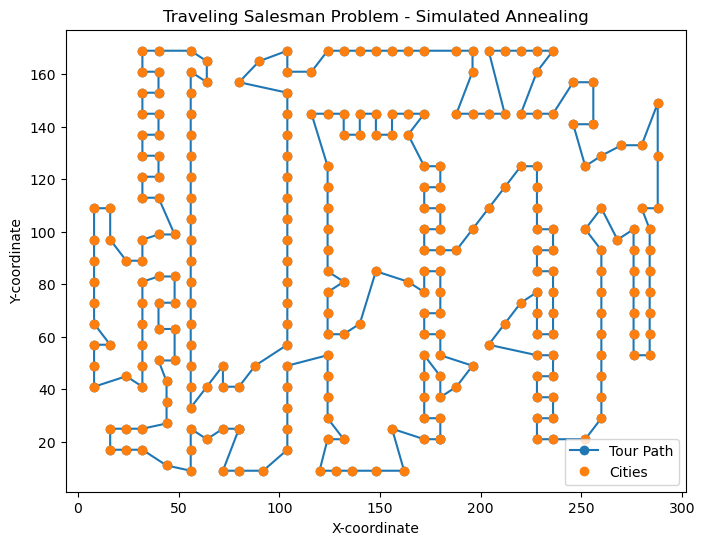

In [48]:
print("Best Tour for A280:", best_tour)
print("Best Distance for A280:", best_distance)
plot_tour(best_tour, cities_a280)

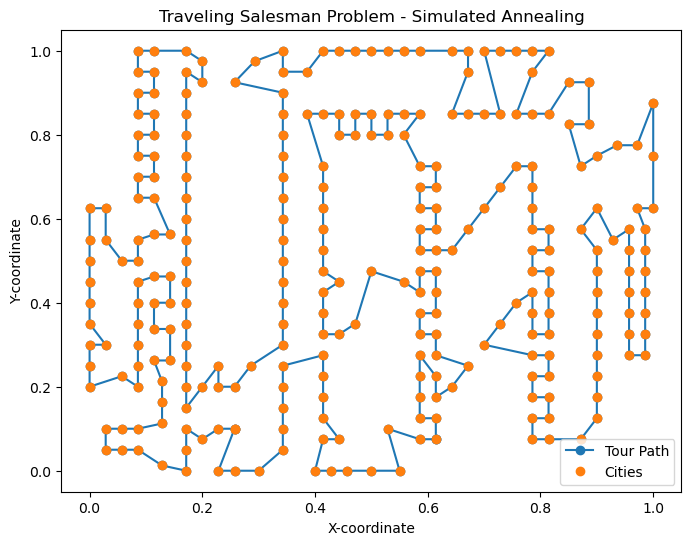

In [50]:
coord_denorm = list(zip(x, y))
plot_tour(best_tour, cities_norm_a280)

In [49]:
best_route_2opt = optimise_with_2opt(best_tour, cities_a280)
best_dist_2opt = calculate_total_distance(best_route_2opt, cities_a280)
print("Best Distance_2opt:", best_dist_2opt)

Best Distance_2opt: 2667.501809907017


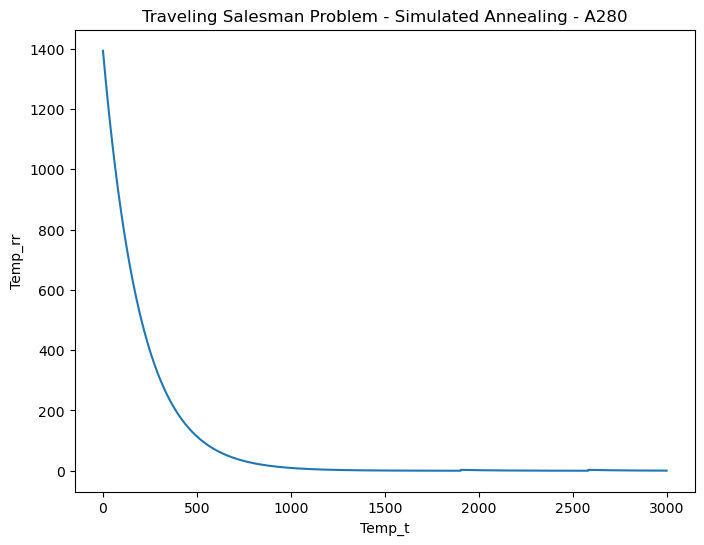

In [51]:
plt.figure(figsize=(8, 6))
plt.plot(temp_t, temp_arr)
plt.title('Traveling Salesman Problem - Simulated Annealing - A280')
plt.xlabel('Temp_t')
plt.ylabel('Temp_rr')
plt.show()

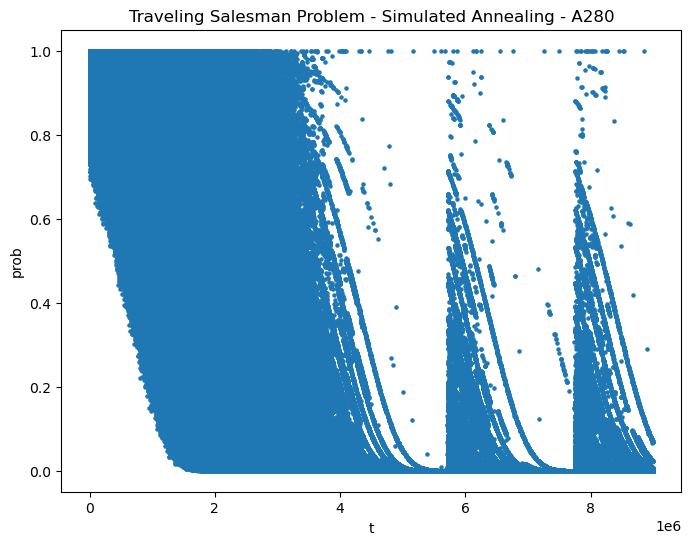

In [52]:
plt.figure(figsize=(8, 6))
plt.scatter(t, prob, s=5, label='Data Points')
plt.title('Traveling Salesman Problem - Simulated Annealing - A280')
plt.xlabel('t')
plt.ylabel('prob')
plt.show()

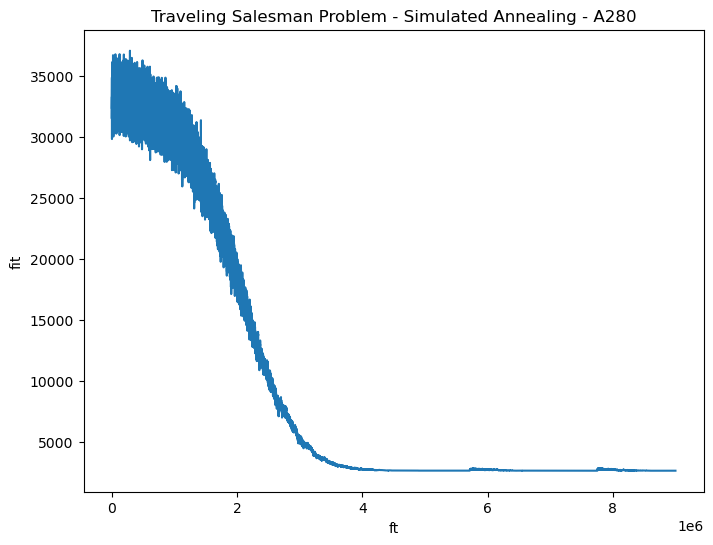

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(ft, fit)
plt.title('Traveling Salesman Problem - Simulated Annealing - A280')
plt.xlabel('ft')
plt.ylabel('fit')
plt.show()

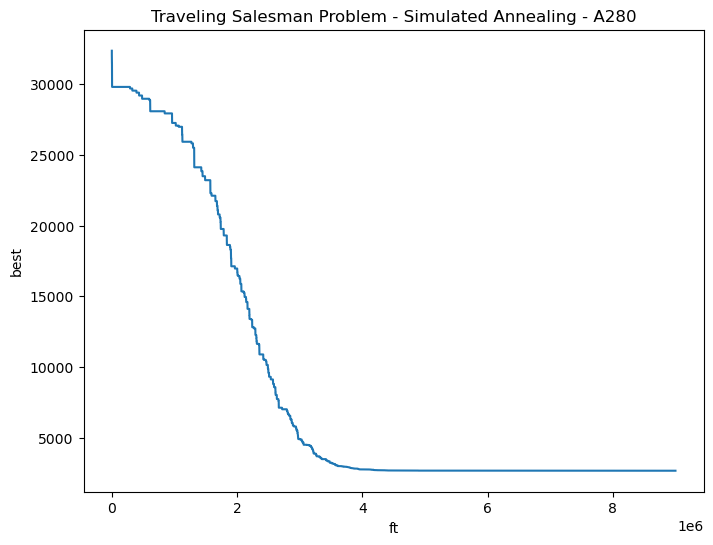

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(ft, best)
plt.title('Traveling Salesman Problem - Simulated Annealing - A280')
plt.xlabel('ft')
plt.ylabel('best')
plt.show()

In [55]:
print(best_dist_2opt)

2667.501809907017


## 3. Test Runs: TSP - Configuration: PCB442

In [56]:
# the name of the csv file you want to read
file_name = 'pcb442.tsp.txt'

# combine the folder path and file name to create the file path
file_path_pcb442 = folder_path + file_name

In [57]:
tsp_file_path_pcb442 = file_path_pcb442
cities_pcb442 = read_tsp_file(tsp_file_path_pcb442)
random.shuffle(cities_pcb442)
cities_norm_pcb442 = normalise_dist(cities_pcb442)
    
initial_temp = 1400
cooling_rate = 0.995 

In [58]:
best_tour_pcb442, best_distance_pcb442, temp_arr, prob, t, fit, ft, temp_t, best_pcb442 = simulated_annealing(cities_pcb442,initial_temp,cooling_rate)

763616.1041477891
763212.1840994739
761738.558425914
759622.1439996582
756349.3393767172
754990.6732734574
753533.7142606609
753146.2894689916
751319.8144423036
749607.344462374
749030.1903669108
746411.3764037166
745740.1433953994
742890.3351987917
739903.1165587979
739160.6529341551
739046.7320489599
737818.0574397078
736903.4064601708
735807.7963914706
735705.0172084578
735595.7247825606
733336.7469641272
733233.8661936768
732973.4557015988
732195.2317294861
731147.2713718228
726700.6559523935
726403.8359449414
725355.7790109662
725055.3455033925
723958.52373362
721301.1061421379
719475.0164609429
718185.6124078654
717173.31828651
715986.8357611956
714263.6388620147
713983.2196239579
712833.5076499459
712210.0954278192
706006.1221800394
705886.1662374098
705849.8617411783
703472.3376584095
702905.0277658699
700241.4458126153
697854.7332507714
696362.701002552
694812.7128189269
694526.3686534541
693072.7262061236
691983.3015204514
688951.0842789687
688918.263859013
686091.5691325385


371328.04403370473
371103.7231927392
369861.5177158618
369315.8852099397
369187.6101153577
369125.88186241727
369023.701622633
368532.23847356095
368259.65363689774
367828.36578172364
367436.1481286504
366920.19771804265
366233.96545646107
365989.9916488631
365734.72647248197
365550.8323712429
364800.5551609421
362947.0502735074
362527.69700006396
362527.4536305564
361334.15935674
361184.52066236973
360811.1833667533
360440.1852125142
360235.97968764737
360216.48108520726
360096.92192172527
359974.2890194845
359550.3102796271
359452.5190164495
358591.44257074565
358457.9125319052
358305.1161544406
358143.63263515406
357953.907699623
357668.0321169359
357661.5062316293
357488.559687297
356702.03249904216
356699.31662717677
355607.03645818715
354909.6882278241
354718.559955072
354669.70043762814
354644.2929636091
354604.8469613872
354488.06792812207
354429.57749495964
353634.11637366994
353446.2012703633
352905.77361829515
352577.7105336882
352568.031768
351463.95168031706
351166.7410164

220325.97800503366
220161.28925876284
219923.2484650655
219494.7101364869
219167.72427333516
219158.86449246624
219088.117395898
218596.48392607245
218405.7494529032
218110.32582601227
218107.8222722989
217779.20837960436
217582.02417165806
217505.34685555505
216969.60348382703
216260.09857793598
216010.36486760003
215818.0028881097
215762.77021945294
215675.50546327492
215084.7473911296
214974.5929550137
214816.16247988938
214632.5824986074
214628.6652951523
214392.1864113706
214247.81749229744
214090.39932245674
214001.5721180181
213327.6792626031
213313.3840367829
212477.21449658496
211980.4289735526
211225.71804242994
211221.2984903332
210966.52169768425
210433.5749081597
210201.119376126
210066.0547970528
210006.71669685474
209964.20148687117
209795.5922555518
209666.24814961824
209582.47591563506
209373.98333770546
208805.61043694452
208584.45101606086
208411.63169180902
208202.47839612243
208169.10235462792
208143.8673427709
207434.81059982502
207200.31929037298
207192.316917122

136177.10523585315
136097.02711233316
135783.9812501238
135671.77124696926
135609.22710674914
135548.67197920274
135541.6226705279
135434.33560451062
135389.85696378475
135386.49286983788
135339.27927433795
135230.55069013475
135093.81663759652
134725.14729804624
134688.85623921177
134673.01816450816
134339.59483145512
134220.98209477306
133939.78748405402
133814.45617982134
133601.6961397539
133473.05819973454
133399.6158075178
133307.6521102129
132924.55692072836
132897.86777612113
132705.24680785427
132696.55323419726
132621.47151167414
132549.05125805494
132221.25121679288
132204.46037282248
132188.62229811883
132044.29493658926
132040.6409488351
131500.14911410635
130861.98769036216
130860.07660191719
130855.41181749894
130638.47186843923
130571.57543112301
130560.2791959348
130529.83434626818
130522.25645813585
130460.82092258915
130376.8286678016
130253.22187005162
130212.92144331994
129938.17216277792
129784.15401143038
129776.8920857741
129740.60102693962
129424.37326092279
12

87294.48002202639
86895.87760711276
86773.37075921618
86720.50313742696
86699.97178103149
86439.41665348512
86352.01344859536
86334.19889010803
86201.65040657713
86166.77968079239
86112.77349864852
86072.29397120455
85896.41905672791
85892.27194873011
85823.8284106068
85712.25818474538
85670.83682850807
85483.03698969299
85229.86089387973
85124.06865461706
85031.58055964894
85008.78074691481
84992.76249960971
84974.94794112239
84846.54514069083
84769.57726864885
84731.3673069453
84707.36591301038
84464.85179304531
84412.50874061238
84400.84146701069
84333.31099282192
84258.08560473644
84253.61257829555
84098.94115285766
84069.83035918212
83883.99633485812
83861.24488764869
83750.52564530453
83694.85300683409
83618.96794887794
83544.77790977346
83529.90051982828
83464.00900312193
83212.78077422109
83174.59157621245
83024.86166673344
82966.6862633947
82942.60542102161
82829.58939562386
82682.39775357855
82631.80870834836
82591.044623073
82452.93599926568
82314.15211475834
82237.758912508

58324.86452342244
58299.70276884322
58243.96081495876
58185.38217119607
58178.30692303537
58120.193040026956
58093.5520321936
58034.9733884309
57976.394744668214
57925.93689743534
57923.65002048809
57828.02221699773
57736.81171240946
57706.53414863626
57705.432791490646
57639.39668665762
57623.833044843996
57540.99033236938
57535.91426193718
57506.58870168528
57488.77414319795
57449.676841472756
57409.9270696075
57348.47425619381
57347.44973038574
57274.97373159079
57234.20964631544
57234.13448915529
57214.07838631555
57202.8790436235
57190.28084785534
57140.31278212541
57110.2880071767
57080.010443403495
57069.27113307686
57019.17018518438
56981.31210520127
56951.88227319053
56865.45487854369
56837.942348901684
56785.47845346
56784.19031585433
56767.30312294345
56763.38591948838
56761.15509205064
56759.28296278864
56749.97302757645
56729.383048973505
56699.14870005747
56674.21885633823
56591.376143863614
56572.32602779417
56568.50808997182
56553.17029804345
56521.98947665145
56495.879

In [59]:
x = [cities_pcb442[city][0] for city in best_tour_pcb442]
y = [cities_pcb442[city][1] for city in best_tour_pcb442]
x.append(x[0])
y.append(y[0])

In [60]:
best_distance_pcb442 = calculate_total_distance(best_tour_pcb442, cities_pcb442)

Best Tour for PCB442: [0, 371, 329, 311, 74, 47, 163, 385, 65, 112, 267, 419, 416, 145, 213, 72, 70, 206, 123, 152, 441, 394, 410, 272, 300, 348, 17, 23, 313, 225, 211, 33, 391, 244, 262, 146, 285, 10, 205, 97, 135, 281, 180, 53, 317, 62, 243, 276, 424, 18, 150, 423, 109, 246, 429, 96, 63, 372, 228, 174, 426, 179, 349, 435, 323, 14, 366, 26, 358, 343, 237, 290, 76, 77, 7, 274, 141, 280, 239, 58, 376, 57, 304, 345, 439, 389, 189, 188, 210, 352, 37, 202, 142, 332, 190, 2, 252, 157, 312, 48, 395, 396, 99, 85, 143, 377, 310, 160, 168, 199, 306, 226, 401, 178, 387, 35, 363, 127, 102, 166, 437, 354, 388, 330, 186, 124, 39, 224, 340, 83, 92, 217, 418, 216, 365, 289, 326, 125, 278, 118, 384, 36, 318, 356, 5, 95, 162, 357, 169, 6, 397, 121, 277, 320, 132, 347, 417, 30, 164, 425, 269, 56, 43, 231, 234, 171, 50, 346, 79, 134, 104, 101, 342, 218, 15, 40, 147, 432, 327, 247, 374, 350, 362, 59, 302, 355, 390, 263, 197, 93, 34, 307, 254, 364, 344, 193, 353, 176, 359, 215, 149, 375, 334, 430, 153, 192

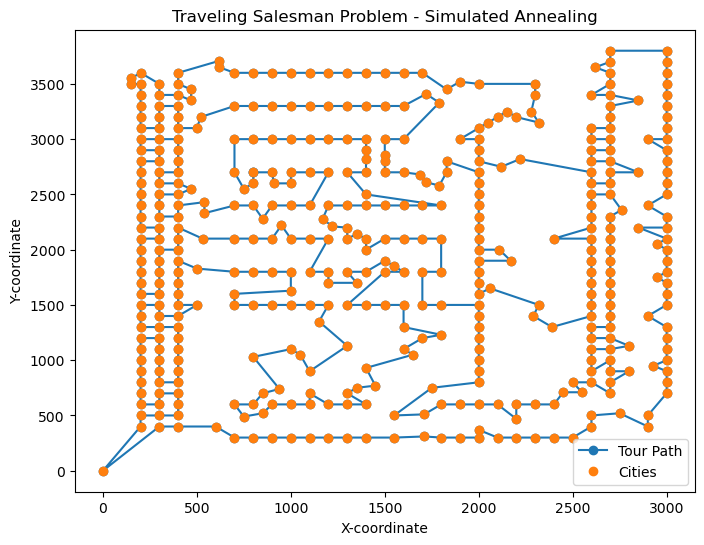

In [61]:
print("Best Tour for PCB442:", best_tour_pcb442)
print("Best Distance for PCB442:", best_distance_pcb442)
plot_tour(best_tour_pcb442, cities_pcb442)

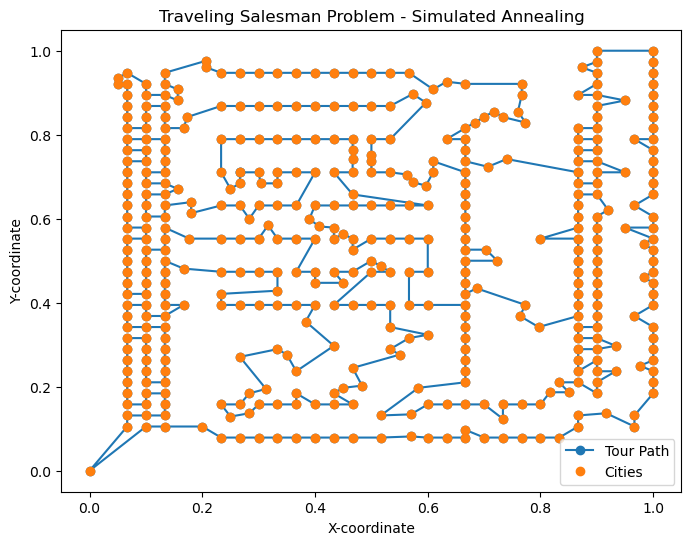

In [62]:
coord_denorm = list(zip(x, y))
plot_tour(best_tour_pcb442, cities_norm_pcb442)

In [63]:
best_route_2opt_pcb442 = optimise_with_2opt(best_tour_pcb442, cities_pcb442)
best_dist_2opt_pcb442 = calculate_total_distance(best_route_2opt_pcb442, cities_pcb442)
print("Best Distance_2opt for PCB442:", best_dist_2opt_pcb442)

Best Distance_2opt for PCB442: 52758.80837887636


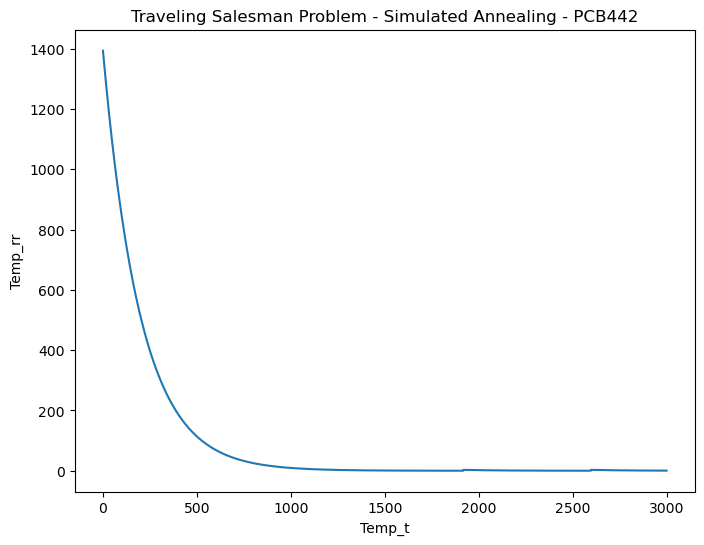

In [64]:
plt.figure(figsize=(8, 6))
plt.plot(temp_t, temp_arr)
plt.title('Traveling Salesman Problem - Simulated Annealing - PCB442')
plt.xlabel('Temp_t')
plt.ylabel('Temp_rr')
plt.show()

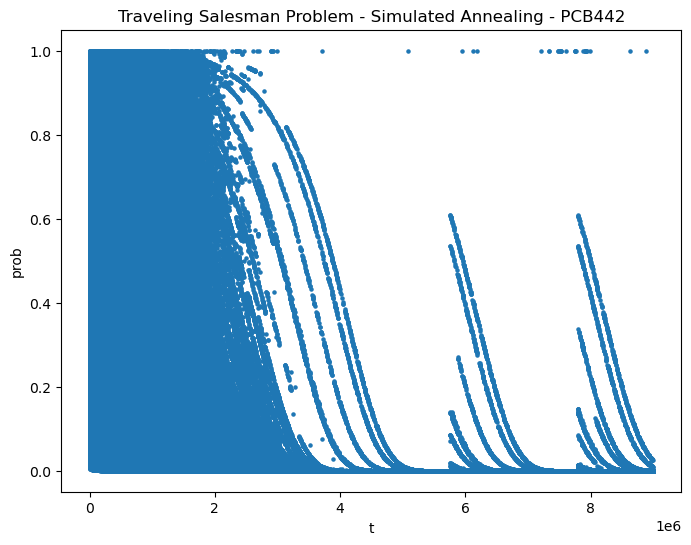

In [65]:
plt.figure(figsize=(8, 6))
plt.scatter(t, prob, s=5, label='Data Points')
plt.title('Traveling Salesman Problem - Simulated Annealing - PCB442')
plt.xlabel('t')
plt.ylabel('prob')
plt.show()

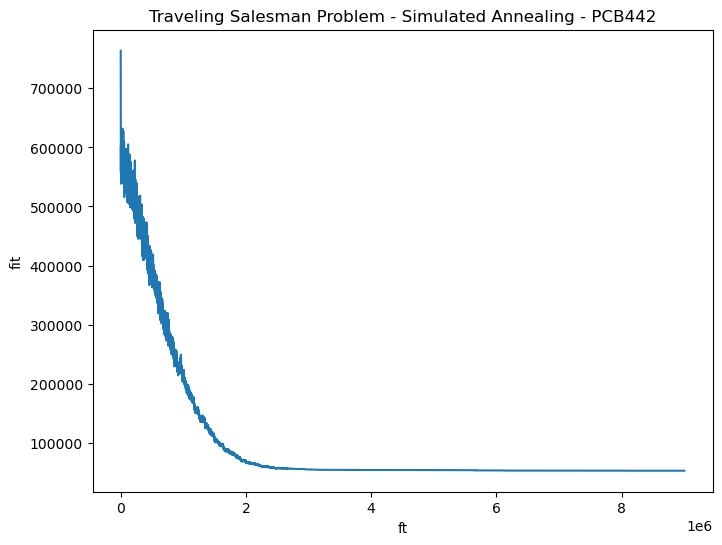

In [66]:
plt.figure(figsize=(8, 6))
plt.plot(ft, fit)
plt.title('Traveling Salesman Problem - Simulated Annealing - PCB442')
plt.xlabel('ft')
plt.ylabel('fit')
plt.show()

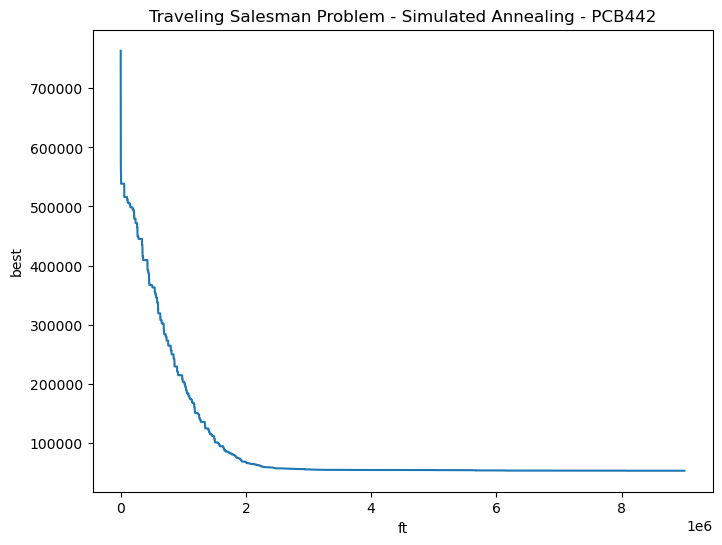

In [69]:
plt.figure(figsize=(8, 6))
plt.plot(ft, best_pcb442)
plt.title('Traveling Salesman Problem - Simulated Annealing - PCB442')
plt.xlabel('ft')
plt.ylabel('best')
plt.show()

In [ ]:
def simulated_annealing_initial(cities):
    """Simulated annealing algorithm"""
    num_cities = len(cities)
    current_tour = list(range(num_cities))
    current_distance = calculate_total_distance(current_tour, cities)
    best_tour = current_tour[:]
    best_distance = current_distance
    temp_array = []
    prob_array = []
    t = []
    fitnes = []
    fitnes_t = []
    temp_t = []
    bb = []
    temp_list = []
    p0 = 0.95
    max_length = 250
    no_progress = 0
    a = [1,1,2,3,3,4]
    """Outer loop to decrease schedule"""
    for inner_ier in range(max_length):
        new_tour = current_tour[:]
        u = random.sample(a, 1)
        if u[0] == 1:
            # 2opt swap
            tik = 1
            i, j = sorted(random.sample(range(1, num_cities), 2))
            new_tour[i:j+1] = list(reversed(new_tour[i:j+1]))
        elif u[0] == 2:
            #move city 
            tik = 2
            new_tour = move_city(new_tour)
        elif u[0] == 3:
            #move part
            tik = 3
            new_tour = move_part(new_tour)
        elif u[0] == 4:
            # Reverse two adjacent nodes
            tik = 4
            i, j = random.sample(range(1, num_cities), 2)
            tem = new_tour[i]
            try: 
                new_tour[i] = new_tour[i+1]
                new_tour[i+1] = tem
            except: 
                new_tour[i] = new_tour[i-1]
                new_tour[i-1] = tem
        # calculate the new tour distance
        new_distance = calculate_total_distance(new_tour, cities)
        delta_distance = new_distance - current_distance
        # decide whether to accept the new tour
        if delta_distance <= 0:
            fitnes.append(new_distance)
            bb.append(best_distance)
            current_tour = new_tour
            current_distance = new_distance
            # update the best tour if needed
            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance
                #print(best_distance)
                no_progress =0
            else:
                no_progress += 1
        else:
                temp_list.append((-delta_distance)/np.log(p0))                     
      
    return temp_list

In [ ]:
tsp_file_path = file_path
cities = read_tsp_file(tsp_file_path)
random.shuffle(cities)
initial_temp_list = simulated_annealing_initial(cities)

In [ ]:
np.mean(initial_temp_list)

In [ ]:
@timeit
def simulated_annealing_list(cities, initial_temperature, cooling_rate, colling_schedule_func, temper_list):
    """Simulated annealing algorithm"""
    num_cities = len(cities)
    current_tour = list(range(num_cities))
    current_distance = calculate_total_distance(current_tour, cities)
    best_tour = current_tour[:]
    best_distance = current_distance
    list_temper = temper_list.copy()
    temperature = np.max(list_temper)
    temp_array = []
    prob_array = []
    t = []
    fitnes = []
    fitnes_t = []
    temp_t = []
    bb = []
    no_progress = 0
    """Outer loop to decrease schedule"""
    for inner_ier in range(2000):
      """Inner loop (Markov Chain length)"""
      temp_list = []
      a = [1,1,2,3,3,4]
      inner_t = 0
      c = 0
      for iteration in range(1000):
        """new_tour1 = current_tour[:]
        new_tour2 = current_tour[:]
        new_tour3 = current_tour[:]
        new_tour4 = current_tour[:]
        u = random.sample(a, 1)
        tik = 1
        i, j = sorted(random.sample(range(1, num_cities), 2))
        new_tour1[i:j+1] = list(reversed(new_tour1[i:j+1]))
        tik = 2
        new_tour2 = move_city(new_tour2)
        tik = 3
        new_tour3 = move_part(new_tour3)
        
        tik = 4
        i, j = random.sample(range(1, num_cities), 2)
        tem = new_tour4[i]
        try: 
            new_tour4[i] = new_tour4[i+1]
            new_tour4[i+1] = tem
        except: 
            new_tour4[i] = new_tour4[i-1]
            new_tour4[i-1] = tem
        tours = [new_tour1, new_tour2, new_tour3, new_tour4]
        new_tour_arg = np.argmin([calculate_total_distance(new_tour1, cities),calculate_total_distance(new_tour1, cities),calculate_total_distance(new_tour1, cities),calculate_total_distance(new_tour1, cities)])
        new_tour = tours[new_tour_arg]"""
        new_tour = current_tour[:]
        u = random.sample(a, 1)
        if u[0] == 1:
            # 2opt swap
            tik = 1
            i, j = sorted(random.sample(range(1, num_cities), 2))
            new_tour[i:j+1] = list(reversed(new_tour[i:j+1]))
        elif u[0] == 2:
            #move city 
            tik = 2
            new_tour = move_city(new_tour)
        elif u[0] == 3:
            #move part
            tik = 3
            new_tour = move_part(new_tour)
        elif u[0] == 4:
            # Reverse two adjacent neigbours
            tik = 4
            i, j = random.sample(range(1, num_cities), 2)
            tem = new_tour[i]
            try: 
                new_tour[i] = new_tour[i+1]
                new_tour[i+1] = tem
            except: 
                new_tour[i] = new_tour[i-1]
                new_tour[i-1] = tem
        # calculate the new tour distance
        new_distance = calculate_total_distance(new_tour, cities)
        delta_distance = new_distance - current_distance
        # decide whether to accept the new tour
        if delta_distance <= 0:
            """a.append(tik)
            if len(a) >= 100:
                a = a[1:]"""
            fitnes.append(new_distance)
            fitnes_t.append((inner_ier)*2000 +iteration) 
            current_tour = new_tour
            current_distance = new_distance
            # update the best tour if needed
            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance
                #print(best_distance)
                no_progress =0
            else:
                no_progress += 1
        else:
            no_progress += 1
            argument = -delta_distance / temperature
            random_u = random.uniform(0, 1)
            prob_array.append(math.exp(argument))
            t.append((inner_ier)*2000 +iteration) 
            if math.exp(argument) > random_u:
                #print((inner_t-delta_distance)/np.log(random_u))
                inner_t += (-delta_distance)/np.log(random_u)
                c +=1
                #temp_list.append((inner_t-delta_distance)/np.log(random_u))
                #temp_list.append(inner_t)
                #print(inner_t)
                current_tour = new_tour
                current_distance = new_distance

            
      #temperature = colling_schedule_func(inner_ier, initial_temperature, temperature, cooling_rate)
      if c > 0:
            list_temper.remove(max(list_temper))
            list_temper.append(inner_t/c)
            temperature = np.max(list_temper)
            #print(temperature)
      if inner_ier % 100 == 0:
                temp_array.append(temperature)
                bb.append(best_distance)
                #print(temperature)
                temp_t.append(inner_ier)      
      #temperature = exponential_cooling(temperature, cooling_rate)
      # Reannealing
      """if temperature < 0.7 and no_progress > 50:
       best_route_2opt = optimise_with_2opt(best_tour, cities)
       best_dist_2opt = calculate_total_distance(best_route_2opt, cities)
       if best_dist_2opt == best_distance or no_progress > 6000:
            temperature = 3
            print("gg")  """              
      
    return best_tour, best_distance ,temp_array, prob_array, t, fitnes, fitnes_t, temp_t, bb

In [ ]:
# Run simulation
if __name__ == "__main__":
    tsp_file_path = file_path
    cities = read_tsp_file(tsp_file_path)
    random.shuffle(cities)
    initial_temp = 0
    cooling_rate = 0
    best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing_list(cities,initial_temp,cooling_rate, exponential_cooling, initial_temp_list)
    best_distance = calculate_total_distance(best_tour, cities)
    """ best_route_2opt = optimise_with_2opt(best_tour, cities)
    best_dist_2opt = calculate_total_distance(best_route_2opt, cities)"""
    print("Best Tour:", best_tour)
    print("Best Distance:", best_distance)
    #print("Best Distance_2opt:", best_dist_2opt)
    plot_tour(best_tour, cities)
    #plot_tour(best_route_2opt, cities)
    plt.plot(temp_t, temp_arr)
    plt.show()
    plt.scatter(t, prob)
    plt.show()
    plt.plot(ft, fit)
    plt.show()
    plt.plot(ft, best)
    plt.yscale('log')
    plt.show()

In [ ]:
types = [exponential_cooling, fast_cooling]
best_distance_list = []
temp_arrs_list = []
fit_arr_list = []
temp_t_arr_list = []
prob_arr_list = []
t_arr_list = []
ft_arr_list = []
best_arr_list = []
best_tour_arr_list = []
temp_arr_list = []

best_distance_file = 'best_distance_list.csv'
temp_file = 'temp_list.csv'
best_arr_lis = 'best_arr_list.csv'

for _ in range(30):
        tsp_file_path = file_path
        cities = read_tsp_file(tsp_file_path)
        random.shuffle(cities)
        initial_temp_list = simulated_annealing_initial(cities)
        initial_temp = 1400
        cooling_rate = 0.995
        best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best,   = simulated_annealing_list(cities,initial_temp,cooling_rate,fast_cooling, initial_temp_list)
        with open(best_distance_file, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([best_distance])
        with open(temp_file, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([temp_arr])
        with open(best_arr_lis, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([best])
        


In [ ]:
#Exponential cooling
def exponential_cooling(iter, initial, temp, rate):
        return temp*rate

In [ ]:
def fast_cooling(iter, initial, temp, rate):
        return initial/(1+iter)

In [ ]:
@timeit
def simulated_annealing_cooling_check(cities, initial_temperature, cooling_rate, cool_func):
    """Simulated annealing algorithm"""
    num_cities = len(cities)
    current_tour = list(range(num_cities))
    current_distance = calculate_total_distance(current_tour, cities)
    best_tour = current_tour[:]
    best_distance = current_distance
    temperature = initial_temperature
    temp_array = []
    prob_array = []
    t = []
    fitnes = []
    fitnes_t = []
    temp_t = []
    bb = []
    no_progress = 0
    """Outer loop to decrease schedule"""
    for inner_ier in range(2000):
      a = [1,1,2,3,3,4]
      """Inner loop (Markov Chain length)"""
      for iteration in range(1000):
        new_tour = current_tour[:]
        u = random.sample(a, 1)
        if u[0] == 1:
            # 2opt swap
            tik = 1
            i, j = sorted(random.sample(range(1, num_cities), 2))
            new_tour[i:j+1] = list(reversed(new_tour[i:j+1]))
        elif u[0] == 2:
            #move city 
            tik = 2
            new_tour = move_city(new_tour)
        elif u[0] == 3:
            #move part
            tik = 3
            new_tour = move_part(new_tour)
        elif u[0] == 4:
            # Reverse two adjacent neigbours
            tik = 4
            i, j = random.sample(range(1, num_cities), 2)
            tem = new_tour[i]
            try: 
                new_tour[i] = new_tour[i+1]
                new_tour[i+1] = tem
            except: 
                new_tour[i] = new_tour[i-1]
                new_tour[i-1] = tem
        # calculate the new tour distance
        new_distance = calculate_total_distance(new_tour, cities)
        delta_distance = new_distance - current_distance
        # decide whether to accept the new tour
        if delta_distance <= 0:
            #a.append(tik)
            fitnes.append(new_distance)
            fitnes_t.append((inner_ier)*2000 +iteration) 
            current_tour = new_tour
            current_distance = new_distance
            # update the best tour if needed
            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance
                #print(best_distance)
                no_progress =0
            else:
                no_progress += 1
        else:
            no_progress += 1
            argument = -delta_distance / temperature
            random_u = random.uniform(0, 1)
            prob_array.append(math.exp(argument))
            t.append((inner_ier)*2000 +iteration) 
            if math.exp(argument) > random_u:
                current_tour = new_tour
                current_distance = new_distance

            

      temperature = cool_func(inner_ier, initial_temperature, temperature, cooling_rate)
      # Reaneiling
      if temperature < 0.7 and no_progress > 6000:
        temperature = 3
        """best_route_2opt = optimise_with_2opt(best_tour, cities)
       best_dist_2opt = calculate_total_distance(best_route_2opt, cities)
       if best_dist_2opt == best_distance or no_progress > 6000:"""
      if inner_ier % 100 == 0:
                temp_array.append(temperature)
                bb.append(best_distance)
                #print(temperature)
                temp_t.append(inner_ier)  
    return best_tour, best_distance ,temp_array, prob_array, t, fitnes, fitnes_t, temp_t, bb

In [ ]:
best_distance_file_fast_cooling = 'best_distance_arr_fast_cooling.csv'
temp_file_fast_cooling = 'temp_fast_cooling.csv'
best_arr_fast_cooling = 'best_arr_fast_cooling.csv'

for iteration in range(30):
        tsp_file_path = file_path
        cities = read_tsp_file(tsp_file_path)
        random.shuffle(cities)
        initial_temp = 1400
        cooling_rate = 0.995
        best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing_cooling_check(cities, initial_temp, cooling_rate, fast_cooling)

        with open(best_distance_file_fast_cooling, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([best_distance])
        with open(temp_file_fast_cooling, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([temp_arr])
        with open(best_arr_fast_cooling, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([best])
        

In [ ]:
best_distanceexp= 'best_distance_arr_fexpon.csv'
temp_fileexp= 'temp_fastexpon.csv'
best_arrexp = 'best_arr_fast_expon.csv'
for _ in range(30):
    tsp_file_path = file_path
    cities = read_tsp_file(tsp_file_path)
    random.shuffle(cities)
    initial_temp = 1400
    cooling_rate = 0.995
    best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best  = simulated_annealing_cooling_check(cities,initial_temp,cooling_rate,exponential_cooling)
    
    with open(best_distanceexp, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([best_distance])
    with open(temp_fileexp, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([temp_arr])
    with open(best_arrexp, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([best])


